In [ ]:
""" Austin Caudill
11/04/2021

Submission for Avery Smith's Data Science Hackathon

Questions to be answered:
What affects open %?​
    Send time, day of week, word count, link count ​
Link sheets No-SQL database​
What link is the most popular?​
What topic is most popular?​
What drives link clicks? ​
How do ads affect? """

In [ ]:
# Load Imports
import os
import pandas as pd
from autoviz.AutoViz_Class import AutoViz_Class
import urllib3
import certifi
import validators
from bs4 import BeautifulSoup
from nltk import ngrams
from collections import Counter
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [ ]:
# Load Data
email_summary = pd.read_excel(r'summary.xlsx', parse_dates=[0])
email_summary['Date'] = email_summary['Date/Time'].dt.date
email_summary['Time'] = email_summary['Date/Time'].dt.time
email_summary['Hour'] = email_summary['Date/Time'].dt.hour
email_summary['Day'] = email_summary['Date/Time'].dt.day_name()

files = os.listdir('link_data')
link_data = pd.DataFrame() # Initialize dataframe
for f in files:
    data = pd.read_excel('./link_data/'+f, 'Sheet1')
    link_data = link_data.append(data)

In [ ]:
# Need to cleanup by removing rows with "nan"
link_data = link_data.dropna()

result = []
# Need to remove bad URLs
for l in link_data['Link']:
    try:
        test = validators.url(l)
        result.append(test)
    except:
        result.append("FAILED")

link_data['Result'] = result
cleaned_URLs = link_data.loc[link_data['Result'] == True]
# Remove filetypes that cannot be scraped.
cleaned_URLs = cleaned_URLs[~cleaned_URLs.Link.str.contains('pdf|jpg|jpeg|JPG|png|cgi|creativecommons')]

# Combine duplicates
cleaned_URLs = cleaned_URLs.groupby(by='Link', as_index=False)[['Clicks']].sum()

threshold = 80 # Minimum number of clicks before a link is evaluated.
cleaned_URLs = cleaned_URLs.loc[cleaned_URLs['Clicks'] > threshold]


Shape of your Data Set loaded: (233, 14)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 233 rows, 13 cols
Data Set columns info:
* Date/Time: 0 nulls, 232 unique vals, most common: {Timestamp('2020-09-04 06:48:55.425000'): 2, Timestamp('2020-07-20 06:47:17.764000'): 1}
* Duration: 0 nulls, 232 unique vals, most common: {'0:05:36.733': 2, '0:00:25.135': 1}
* Sends: 0 nulls, 213 unique vals, most common: {743: 2, 829: 2}
* Opens: 0 nulls, 213 unique vals, most common: {1075: 2, 585: 2}
* Clicks: 0 nulls, 176 unique vals, most common: {40: 4, 54: 3}
* Click Rate: 0 nulls, 227 unique vals, most common: {0.174: 2, 0.1399: 2}
* Unsubscribes: 0 nulls, 9 unique vals, most common: {0: 91, 1: 67}
* Word Count: 0 nulls, 120 unique vals, most common: {460: 5, 494: 5}
* Link Count: 0 nulls, 44 unique vals, most common: {29: 16, 28: 15}
* Date: 0 nulls, 232 unique vals, most common: {datetime.date(2020, 9, 4): 2, dat

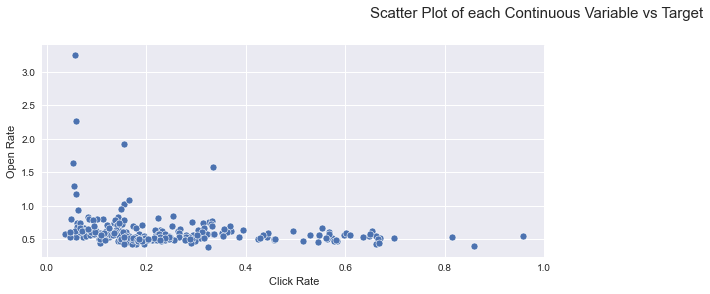

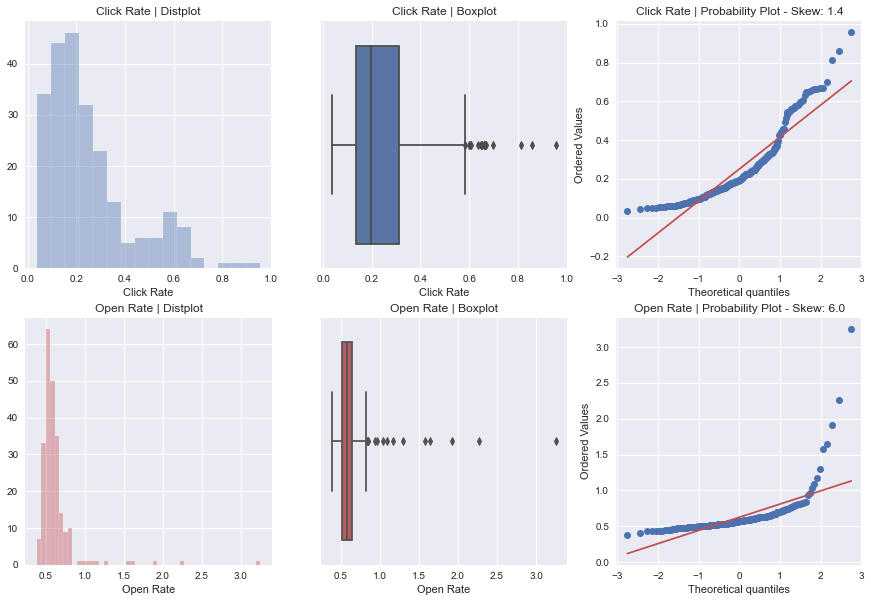

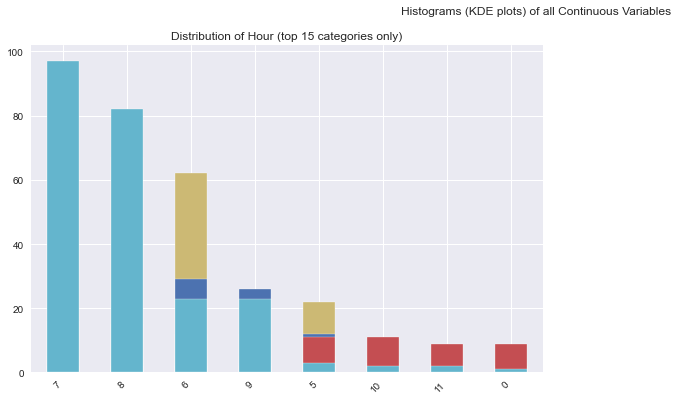

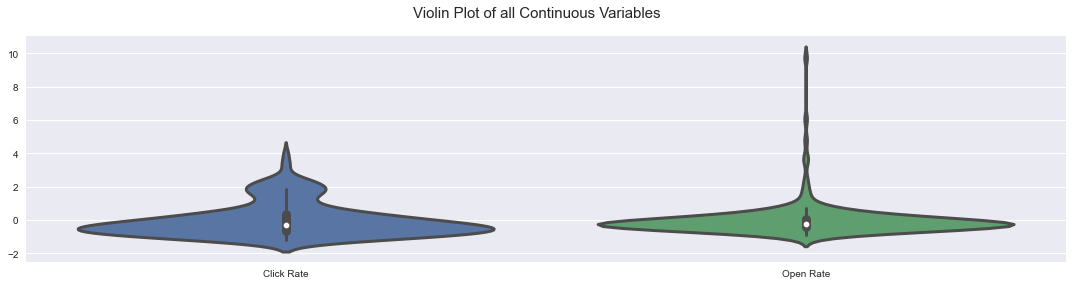

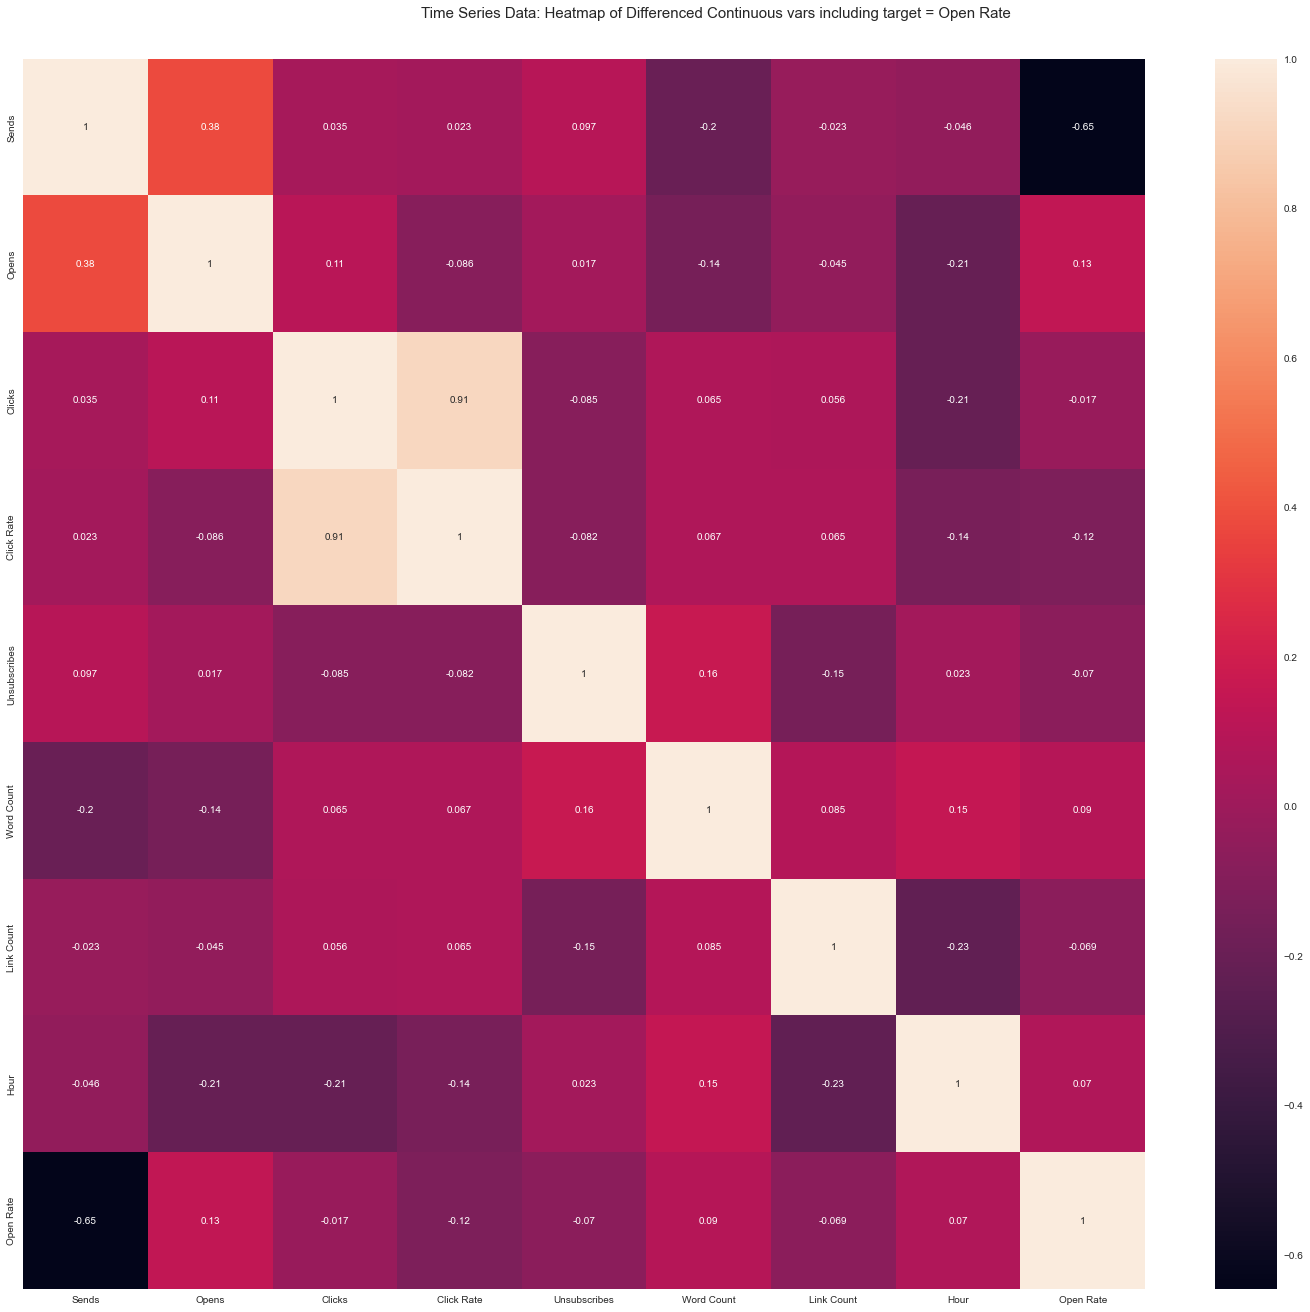

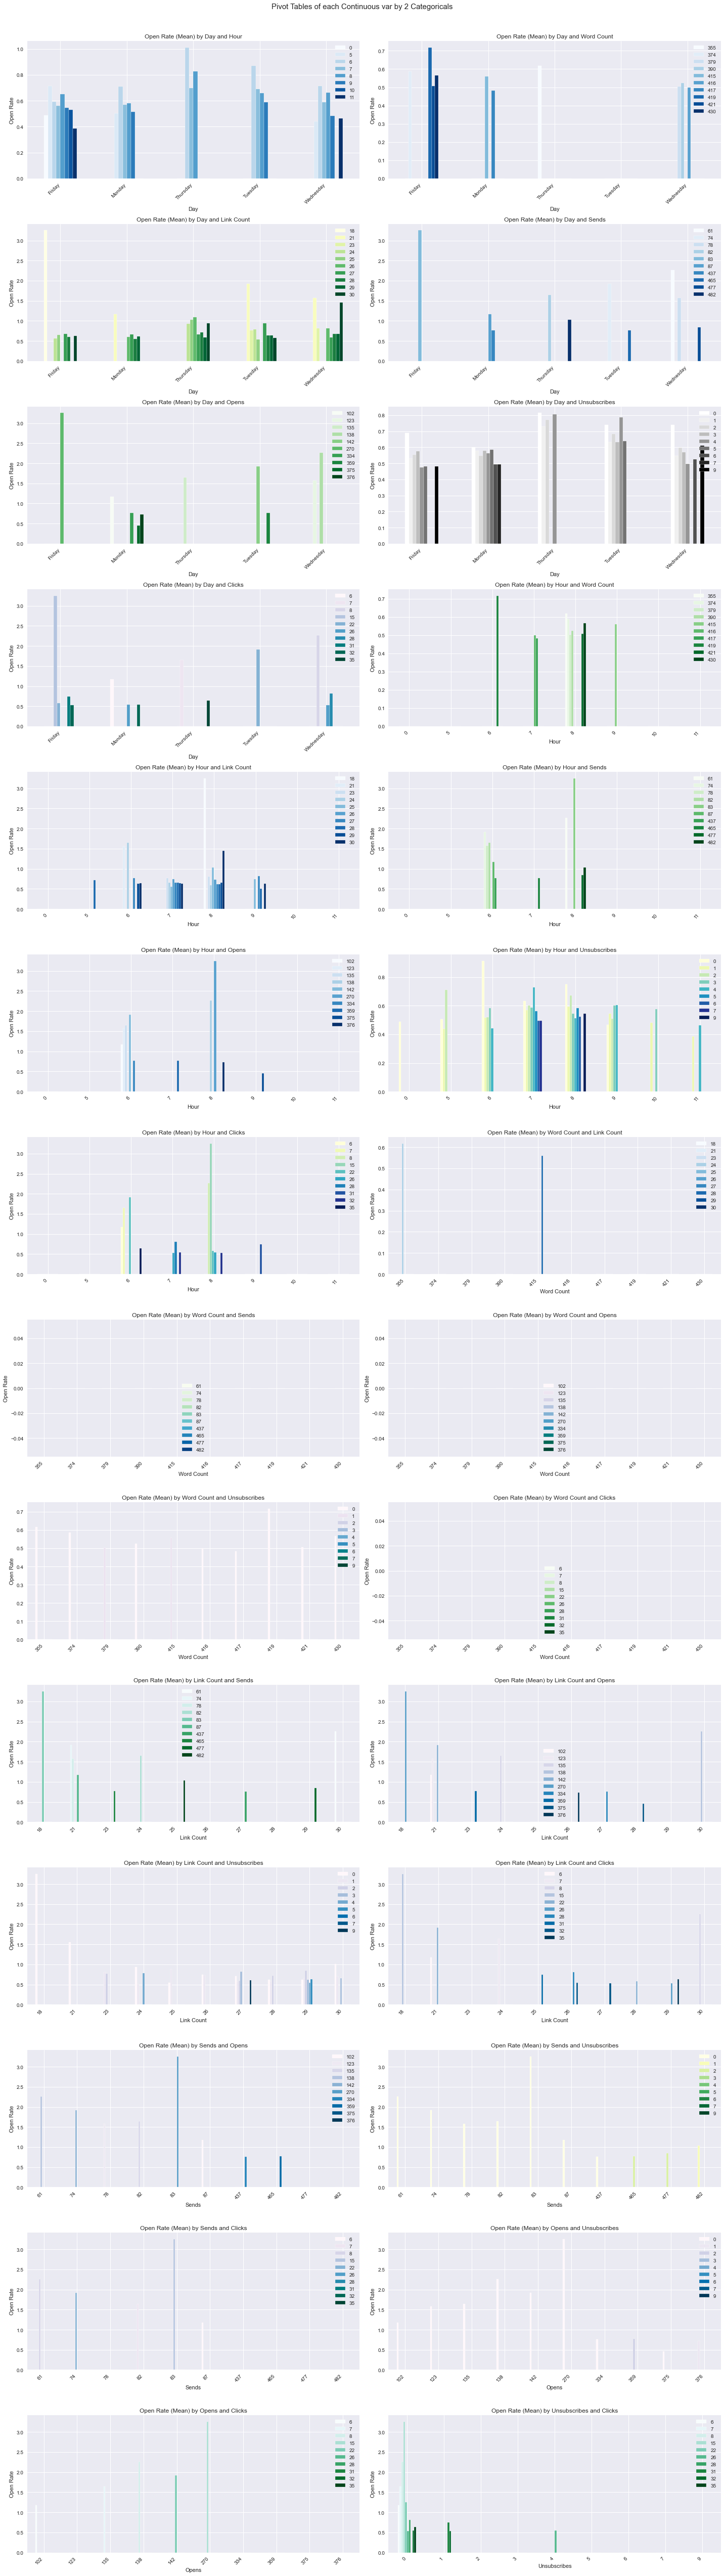

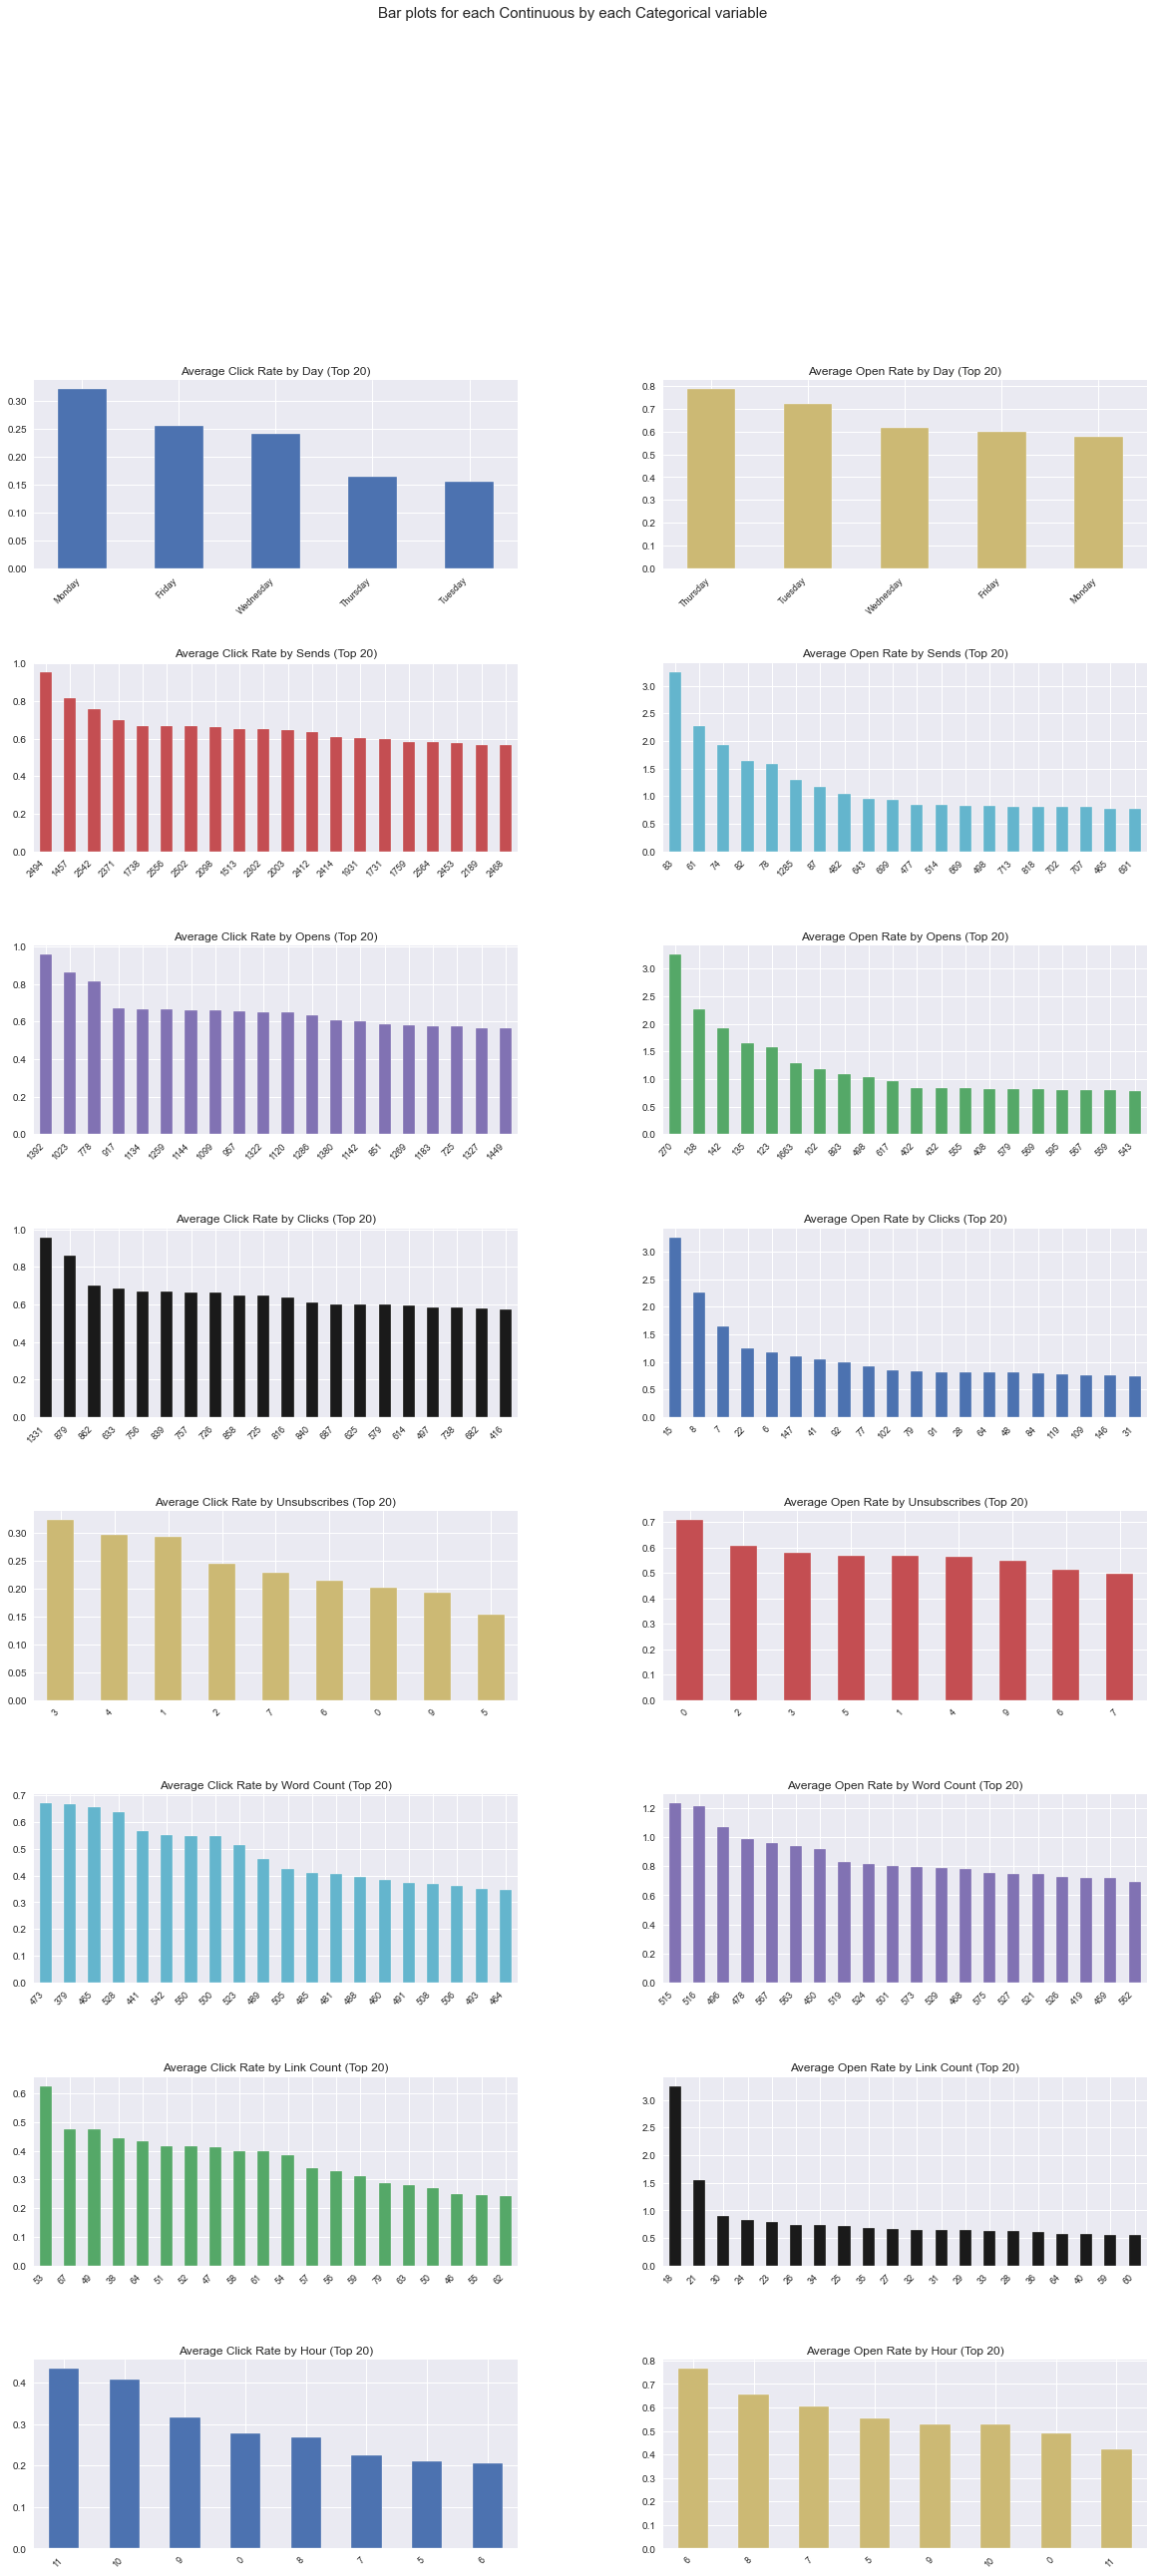

In [8]:
# Perform EDA
AV = AutoViz_Class()
filename = "" # Not Needed
dft = AV.AutoViz(
    filename,
    sep=",",
    depVar="Open Rate", # Target Variable
    dfte=email_summary,
    header=1,
    verbose=2,
    lowess=False,
    chart_format="svg",
)

Getting: https://dynea.com/about-dynea/company-overview/
Getting: https://electrical-engineering-portal.com/arriving-at-the-scene-of-a-pole-fire-what-to-do
Getting: https://en.wikipedia.org/wiki/Arkema
Getting: https://en.wikipedia.org/wiki/BASF
Getting: https://en.wikipedia.org/wiki/Dow_Chemical_Company
Getting: https://en.wikipedia.org/wiki/ExxonMobil
Getting: https://en.wikipedia.org/wiki/LyondellBasell
Getting: https://en.wikipedia.org/wiki/Polyethylene_terephthalate
Getting: https://en.wikipedia.org/wiki/Polyurethane
Getting: https://en.wikipedia.org/wiki/Royal_Dutch_Shell
Getting: https://givebutter.com/thecolumn
Getting: https://gp-chemicals.com/formaldehyde/
Getting: https://ihsmarkit.com/research-analysis/the-alpha-dogs-of-alpha-olefins.html
Getting: https://muratechnology.com/sites-projects/
Getting: https://muratechnology.com/technology/
Getting: https://nacero.co/company
Getting: https://thecolumn.co/
Getting: https://thecolumn.co/daily/01182021
Getting: https://thecolumn.c

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

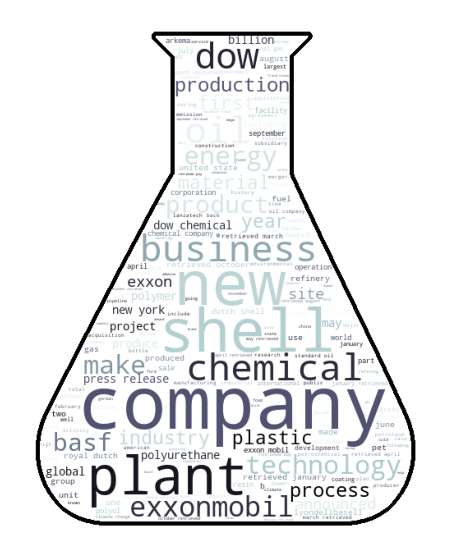

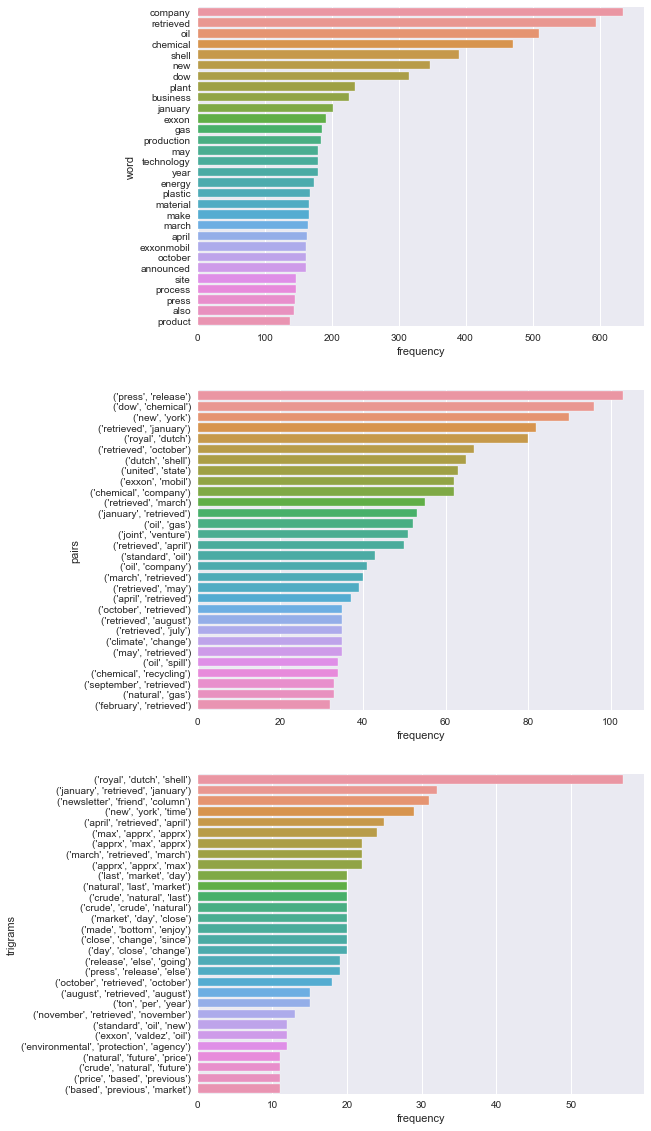

In [9]:
# Time to scrape link data
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',ca_certs=certifi.where())
soupey = []
for link in cleaned_URLs['Link']:
    try:
        print("Getting:", link)
        req = http.request('GET', link, headers=headers, retries=urllib3.Retry(redirect=2, raise_on_redirect=False))
        if req.status != 200: 
            continue
        soup = BeautifulSoup(req.data, "html.parser")
        body = soup.find('body')
        text = body.get_text()
        soupey.append(text)
    except:
        print('failed')
        continue


# Text Preprocessing
stop_words = set(stopwords.words('english'))
stop_words_ext = ['http','n', 'please', 'nthe', 'license', 'cc', 'nmore', 'xa', 'c', 'u', 'r', 'f', 'licensing','licensed', 'licenses', 'creative commons','used','copyright','ha','wa','edit', 'archived', 'original'] # custom word exclusion list.

def preprocess(text):

    new_tokens = word_tokenize(text)
    new_tokens = [t for t in new_tokens if t.isalpha()]
    new_tokens = [t.lower() for t in new_tokens]

    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]

    cleaned_words = []
    # remove stopwords
    for word in new_tokens:
        if word not in stop_words and word not in stop_words_ext:
            cleaned_words.append(word)
    
    #counts the words, pairs and trigrams
    counted = Counter(cleaned_words)
    counted_2= Counter(ngrams(cleaned_words,2))
    counted_3= Counter(ngrams(cleaned_words,3))
    #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)

    return cleaned_words,word_freq,word_pairs,trigrams


soupey = str(soupey)
cleaned_soupey,word_freq,word_pairs,trigrams = preprocess(soupey)    

number_of_words = len(cleaned_soupey)


cleaned_soupey = " ".join(cleaned_soupey)


mask = np.array(Image.open("flask3.png"))
wordcloud = WordCloud(background_color ='white', prefer_horizontal=1, mask=mask, contour_width=5, contour_color='black', colormap='bone').generate((cleaned_soupey))

# plot the WordCloud image 
plt.figure( figsize=(20,10) )                       
plt.imshow(wordcloud)
plt.axis("off")





# create subplot of the different data frames
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))

In [10]:
print("Script Finished")

Script Finished
